# Hockey games analysis
## Bayesian data analysis
### Group A: Christian Berchtold, Andrea Wey

In this project, we analyse the hockey season played in the Swiss National League, using the seasons from 2015 to 2022. We chose to perform our analysis using the HC Lugano team's perspective, to show its strengths and compare it to the other teams. The data was taken from this page: https://www.sihf.ch/de/game-center/national-league/#/results/date/asc/page/0/2016/all/09.09.2015-12.04.2016//all/all.

In [44]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)

In [45]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 1.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Data cleaning and preprocessing

We concatenate all the files representing the different seasons together, to have a single large file containing all the games.

In [46]:
df = pd.read_csv("data_hockey/hockey_21-22.csv", sep=";")
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,TV/Online,Id,Liga,Region,Phase
0,Di,07.09.2021,19:45,HC Ajoie,EHC Biel-Bienne,1:3,0:0|1:2|0:1,NaN,Ende,False,"Raiffeisen Arena, 2900 Porrentruy JU",3325,MYSPORTS,20221105000001,NL,CH,Regular Season
1,Di,07.09.2021,19:45,SC Bern,Fribourg-Gottéron,3:6,0:2|2:0|1:4,NaN,Ende,False,"PostFinance-Arena, 3014 Bern BE",12700,MYSPORTS,20221105000002,NL,CH,Regular Season
2,Di,07.09.2021,19:45,ZSC Lions,Genève-Servette HC,4:2,0:0|3:0|1:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",6882,MYSPORTS,20221105000003,NL,CH,Regular Season
3,Di,07.09.2021,19:45,EV Zug,HC Davos,5:2,2:0|0:0|3:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",6427,MYSPORTS,20221105000006,NL,CH,Regular Season
4,Mi,08.09.2021,19:45,HC Lugano,SC Rapperswil-Jona Lakers,2:0,1:0|0:0|1:0,NaN,Ende,False,"Cornèr Arena, 6948 Porza Ti",4872,MYSPORTS,20221105000005,NL,CH,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Sa,23.04.2022,20:00,EV Zug,ZSC Lions,1:2,1:0|0:0|0:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,"SRF,RTS,RSI,MYSPORTS",20221105000413,NL,CH,Playoff Final
377,Mo,25.04.2022,20:00,ZSC Lions,EV Zug,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,"SRF,RTS,RSI,MYSPORTS",20221105000414,NL,CH,Playoff Final
378,Mi,27.04.2022,20:00,EV Zug,ZSC Lions,4:1,0:0|1:1|3:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,"SRF,RTS,RSI,MYSPORTS",20221105000415,NL,CH,Playoff Final
379,Fr,29.04.2022,20:00,ZSC Lions,EV Zug,0:2,0:1|0:0|0:1,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,"SRF,RTS,RSI,MYSPORTS",20221105000416,NL,CH,Playoff Final


In [47]:
df.Resultat.unique()

array([' 1:3', ' 3:6', ' 4:2', ' 5:2', ' 2:0', ' 3:2', ' 3:1', ' 1:4',
       ' 1:2', ' 3:4', ' 6:2', ' 4:6', ' 4:5', ' 5:4', ' 2:7', ' 4:3',
       ' 8:1', ' 5:3', ' 2:1', ' 3:5', ' 4:0', ' 3:0', ' 5:1', ' 2:6',
       ' 0:3', ' 6:0', ' 2:5', ' 2:3', ' 1:0', ' 4:1', ' 6:3', ' 4:10',
       ' 0:1', ' 1:5', ' 2:4', ' 9:3', ' 0:5', ' 7:5', ' 0:2', ' 6:5',
       ' 8:0', ' 6:1', ' 4:8', ' 8:2', ' 1:6', ' 5:6', ' 7:0', ' 6:4',
       ' 0:0', ' 8:7', ' 5:0', ' 3:7', ' 0:4', ' 7:3', ' 11:0', ' 4:7',
       ' 8:4', ' 7:2', ' 1:9'], dtype=object)

In [48]:
df = df.loc[df.Resultat != " -:-"]

In [49]:
df = df[['Home', 'Away', 'Resultat', 'Datum']]
df[['result_home', 'result_away']] = df['Resultat'].str.split(':', expand=True)
df['result_home'] = df['result_home'].astype(int)
df['result_away'] = df['result_away'].astype(int)
df = df.drop("Resultat", axis=1)
df.reset_index(drop=True)

,Home,Away,Datum,result_home,result_away
0,HC Ajoie,EHC Biel-Bienne,07.09.2021,1,3
1,SC Bern,Fribourg-Gottéron,07.09.2021,3,6
2,ZSC Lions,Genève-Servette HC,07.09.2021,4,2
3,EV Zug,HC Davos,07.09.2021,5,2
4,HC Lugano,SC Rapperswil-Jona Lakers,08.09.2021,2,0
...,...,...,...,...,...
376,EV Zug,ZSC Lions,23.04.2022,1,2
377,ZSC Lions,EV Zug,25.04.2022,1,4
378,EV Zug,ZSC Lions,27.04.2022,4,1
379,ZSC Lions,EV Zug,29.04.2022,0,2


In [50]:
def winner(home, away):
    if home>away:
        return "H"
    else:
        return "A"
    
df['Winner'] = df.apply(lambda x: winner(x['result_home'], x['result_away']), axis=1)

In [51]:
# Home games
df_lugano = df[df['Home'] == "HC Lugano"]
df_lugano['Win'] = df_lugano['Winner'] == "H"
df_lugano['Place'] = 0
df_lugano['Difference'] = df_lugano['result_home']- df_lugano['result_away']
df_lugano = df_lugano.drop(['Home','Winner', 'result_home', 'result_away'], axis=1)
df_lugano.columns = ['Opponent','Date', 'Win', 'Place', 'Difference']

# Away games
df_lugano_out = df[df['Away'] == "HC Lugano"]
df_lugano_out['Win'] = df_lugano_out['Winner'] == "A"
df_lugano_out['Place'] = 1
df_lugano_out['Difference'] = df_lugano_out['result_away']- df_lugano_out['result_home']
df_lugano_out = df_lugano_out.drop(['Away','Winner', 'result_home', 'result_away'], axis=1)
df_lugano_out.columns = ['Opponent','Date', 'Win', 'Place', 'Difference']

# Final merge
df = pd.concat([df_lugano, df_lugano_out]).reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df = df.sort_values(by='Date',ascending=True)

df['Rest_days'] = df["Date"].diff()

df = df.dropna().reset_index(drop=True)
df['Rest_days'] = df['Rest_days'].apply(lambda x: x.days)
df

,Opponent,Date,Win,Place,Difference,Rest_days
0,SCL Tigers,2021-09-10,False,0,-3,2
1,HC Ajoie,2021-09-14,True,1,5,4
2,EHC Biel-Bienne,2021-09-17,False,0,-2,3
3,Genève-Servette HC,2021-09-18,True,1,2,1
4,EV Zug,2021-09-21,True,0,1,3
5,ZSC Lions,2021-09-24,False,1,-3,3
6,SC Bern,2021-09-25,True,0,2,1
7,Fribourg-Gottéron,2021-09-28,False,1,-1,3
8,HC Ambri-Piotta,2021-10-01,True,1,1,3
9,Lausanne HC,2021-10-02,False,0,-3,1


# Exploratory data analysis

In [52]:
# list of teams
team_idx, teams = pd.factorize(df["Opponent"], sort=True) # 0 = Home
n_teams = teams.shape[0]

# code and name of each team
team_lookup = dict(zip(teams, np.arange(n_teams)))

place = df.Place.values

# y
result = df.Difference.values

Text(0.5, 1.0, 'Difference of goals')

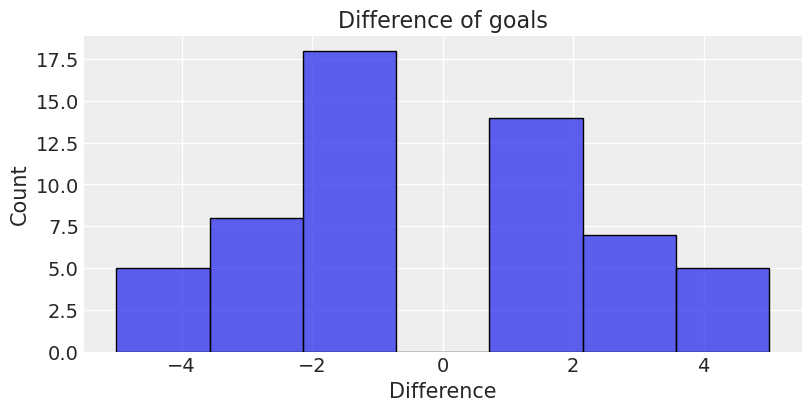

In [53]:
# Distribution of results in home stadium
sns.histplot(df.Difference).set_title('Difference of goals')

Text(0, 0.5, 'number of goals difference')

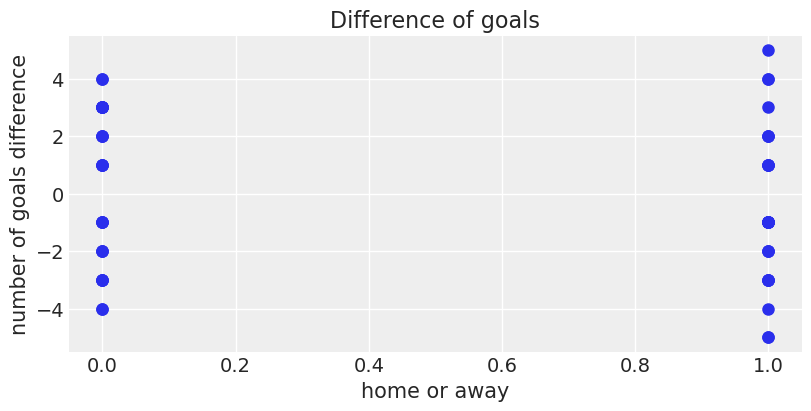

In [54]:
plt.scatter(place, result)
plt.title('Difference of goals')
plt.xlabel('home or away')
plt.ylabel('number of goals difference')

Text(0.5, 1.0, 'Count of won and lost games')

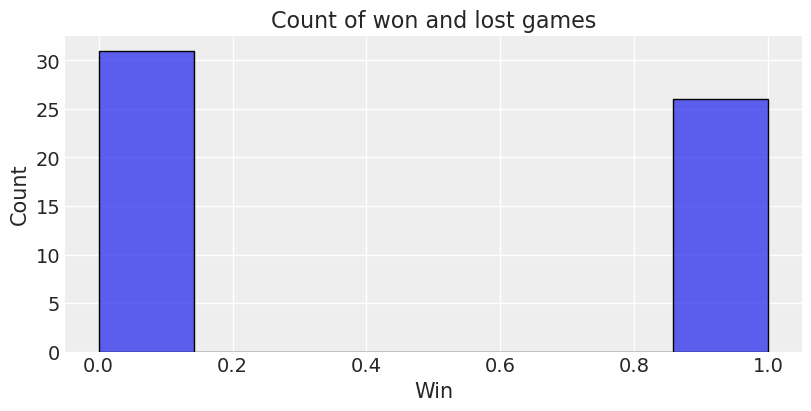

In [55]:
sns.histplot(df.Win).set_title('Count of won and lost games')

We see that the wins are slightly unbalanced, but this is not a problem.

# Models

## Pooled regression

A regression model which ignores the team:

$$Y \sim N( \alpha + \beta X, \sigma)$$


* $Y$: difference of goals (413 measures)

* $X$: home or away (0 or 1)

* $\alpha$ : intercept.  (on  centered data, it represents the mean result for HC Lugano). 



* We use the centered covariate  $X_t = X - \bar{x}$


* We have no prior knowledge and thus we use fall back to  weakly informative, data-dependent, priors:

\begin{align}
Y  &\sim N( \alpha_t + \beta X_t,  \sigma) && \text{likelihood}\\
\alpha &\sim N(\bar{y},2 s_y) && \text{prior on the intercept} \\
\beta  & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y )&& \text{prior on the dev std } \\
\end{align}

# Unpooled regression 


$$ Y \sim N( \alpha_{\text{team}[i]} + \beta X, \sigma) $$


* $\alpha_{\text{team}[i]}$ : the intercept for the team where the $i$-th observation has been made



*  For each team we have a different independent intercept $\alpha_1, \alpha_2, .. \alpha_j ... \alpha_{12}$ 





$$ Y \sim N( \alpha_{\text{team}[i]} + \beta X, \sigma) $$

* The slope $\beta$ is equal for all teams; we assume that the difference between home and away does not depend on the teams.



\begin{align}
Y  &\sim N( \alpha_{\text{team}} + \beta X_t,  \sigma) && \text{likelihood}\\
\alpha_j &\sim N(\bar{y},2 s_y) \,\, j=1,2..., 12&& \text{prior on the intercept} \\
\beta & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
\end{align}

# Discussion

* The pooled model assumes  all observations to be samples from the same process, ignoring the team.


* The unpooled model learns from scratch the intercept (baseline level) of every team, without transferring any information between the different teams.

The pooled model has been developed for both hypothesis, while all the other models have been developed just for the firs hypothesis, since, to our advice, it did not made sense to separate teams, as we thought it would have introduced their strength as variable.

# Pooled
## Hypothesis 1

In [56]:
#centering is needed to have effective sampling
place_c = (place - place.mean())
mu_y = result.mean()
s_y = result.std()
s_x = place_c.std()

with pm.Model() as pooled_model:
    alpha = pm.Normal('alpha', mu= mu_y,  sigma= 2 * s_y)
    beta = pm.Normal('beta', mu=0,  sigma= 2.5 * s_y/s_x)
    sigma = pm.HalfNormal('sigma', 1.5 * s_y)
    y = pm.Normal('y', alpha + beta * place_c, sigma, observed=result)

In [57]:
with pooled_model:
    pooled_trace = pm.sample(draws=2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.


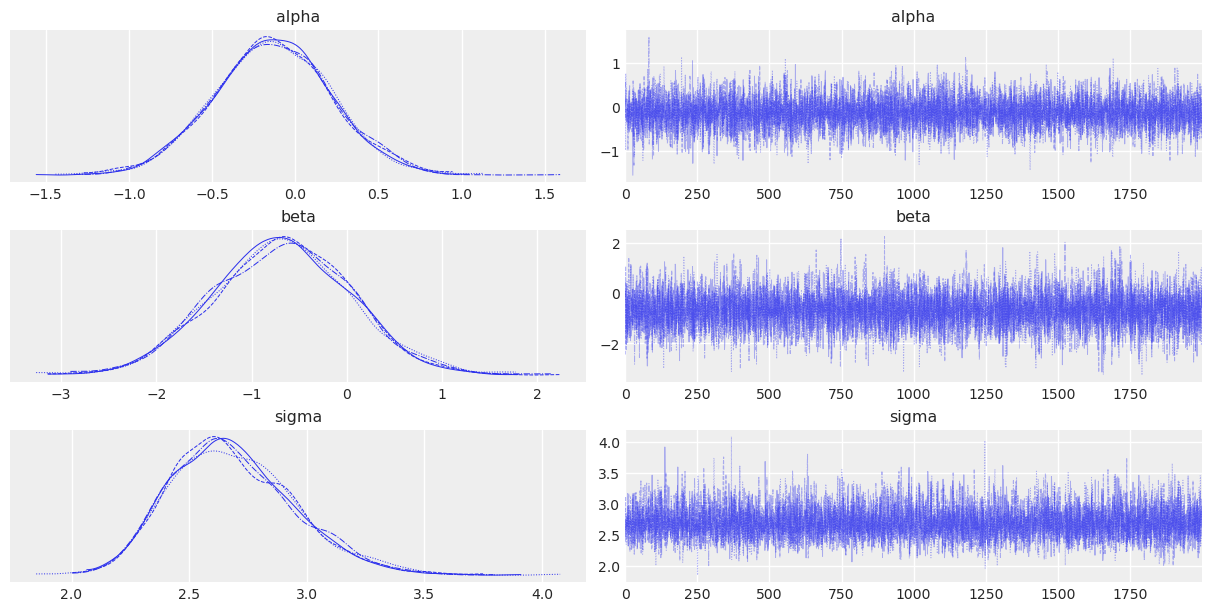

In [58]:
az.plot_trace(pooled_trace)
plt.show()

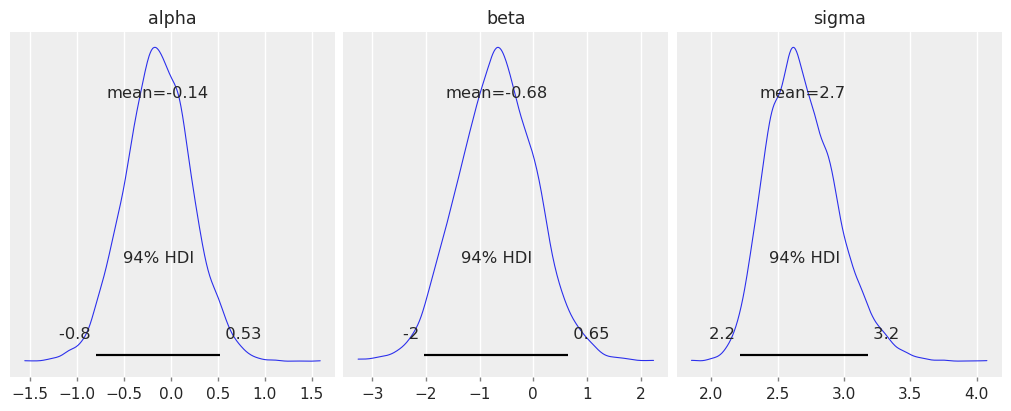

In [59]:
with pooled_model:
    az.plot_posterior(pooled_trace, figsize=(10,4), textsize=11)

From the above posterior we undertand that the value for the slope is negative, meaning that our hypothesis is indeed correct: apparently the selected team (HC Lugano, but this is probably for every team) is performing better in its own stadium compared to games in foreign ones.

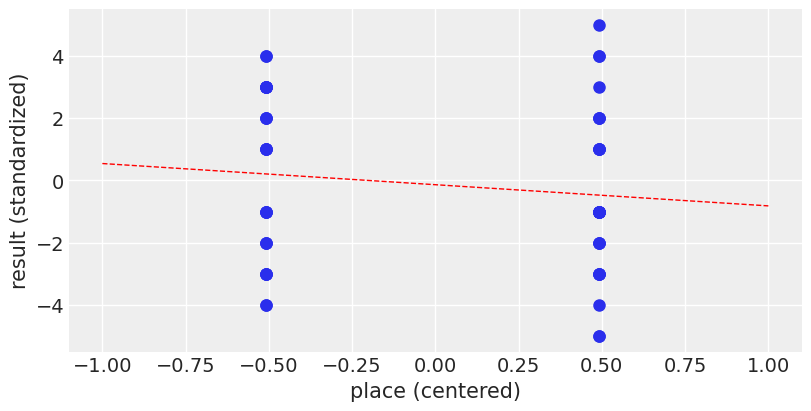

In [60]:
# posterior mean of the parameters
post_pooled = az.extract_dataset(pooled_trace)
a_pooled =  post_pooled.alpha.values.mean()
b_pooled = post_pooled.beta.values.mean()

plt.scatter(place_c, result)
xvals = np.linspace(-1, 1)
plt.plot(xvals, b_pooled * xvals + a_pooled, 'r--')
plt.xlabel('place (centered)')
plt.ylabel('result (standardized)');

The pooled model shows that in the away stadium, HC Lugano performs worse than when in the home stadium.

## Hypothesis 2

In [61]:
win = df['Win'].values
rest_c = (df['Rest_days'].values - df['Rest_days'].values.mean())
mu_y_h2 = win.mean()
s_y_h2 = win.std()
s_x_h2 = rest_c.std()

with pm.Model() as h2_model:
    # Prior for the intercept
    alpha_h2 = pm.Normal("alpha", mu=mu_y_h2, sigma=2 * s_y_h2)
    # Prior for the slope
    beta_h2 = pm.Normal("beta", mu=0, sigma=2.5 * s_y_h2/s_x_h2)
    # Log-odds of the outcome
    log_odds = alpha_h2 + beta_h2 * np.array(rest_c)
    # Probability of the outcome
    p_h2 = pm.math.invlogit(log_odds)
    # Likelihood of the data
    y_h2 = pm.Bernoulli("y", p=p_h2, observed=win)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.


array([<AxesSubplot: title={'center': 'alpha'}>,
       <AxesSubplot: title={'center': 'beta'}>], dtype=object)

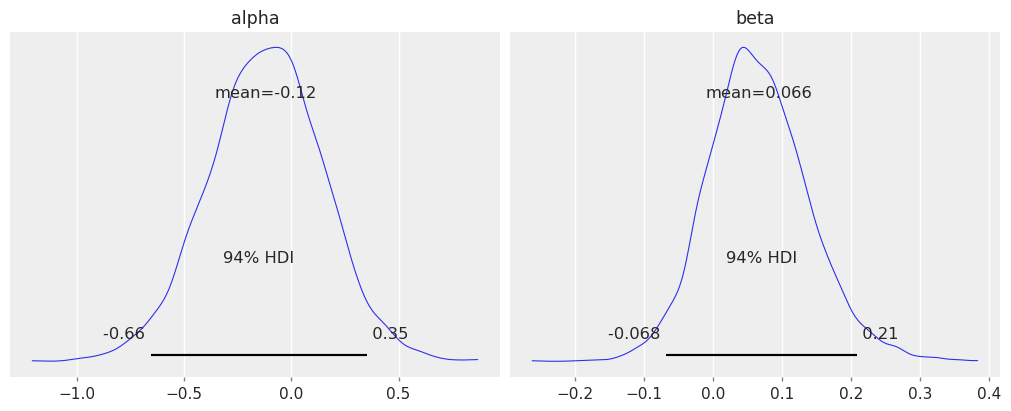

In [62]:
with h2_model:
    h2_trace = pm.sample(2000, tune=2000, return_inferencedata=True)
    
az.plot_posterior(h2_trace, figsize=(10,4), textsize=11)

Text(0, 0.5, 'rest days (centered)')

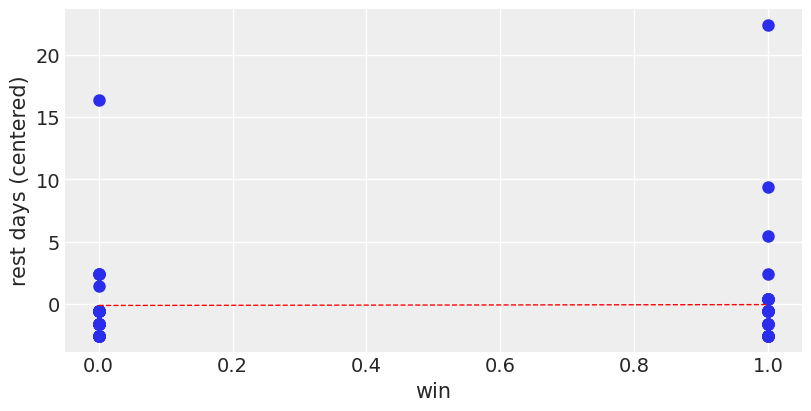

In [63]:
# posterior mean of the parameters
h2_post = az.extract_dataset(h2_trace)
a_h2 = h2_post.alpha.values.mean()
b_h2 = h2_post.beta.values.mean()

plt.scatter(win, rest_c)
xvals = np.linspace(0, 1)
plt.plot(xvals, b_h2 * xvals + a_h2, 'r--')
plt.xlabel('win')
plt.ylabel('rest days (centered)')

For the second hypothesis, we gather from this plot that the resting days have no influence on the outcome of the game.

 # Unpooled regression (only for hypothesis 1 from now on)

In [64]:
with pm.Model() as unpooled_model:
    # a different intercept for each county
    alpha = pm.Normal('alpha', mu=mu_y, sigma=2 * s_y, shape=n_teams)

    # the slope is the same for all counties
    beta = pm.Normal('beta', mu=0, sigma=2 * s_y/s_x)
    sigma_y = pm.HalfNormal('sigma_y', 1.5 * s_y)
    
    #county is a vector containing the county index  for each measure.
    mu = alpha[team_idx] + beta * place_c
    
    y = pm.Normal('y', mu, sigma=sigma_y, observed=result)
    

In [65]:
with unpooled_model:
    unpooled_trace = pm.sample(draws=2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


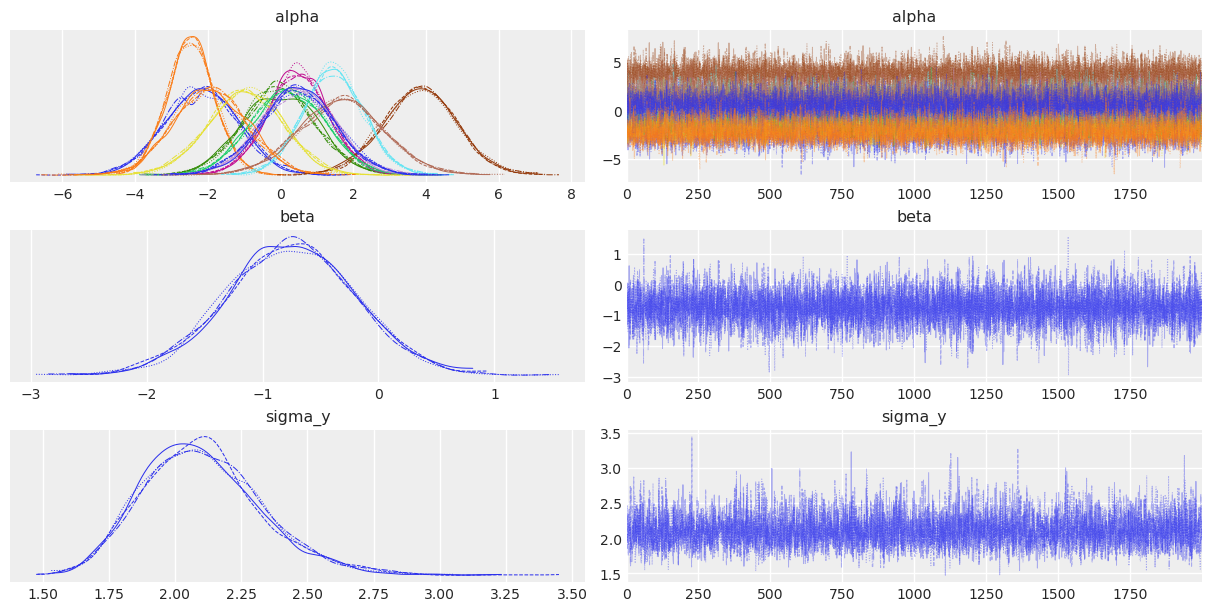

In [66]:
az.plot_trace(unpooled_trace)
plt.show()

In [67]:
unpooled_trace.posterior = unpooled_trace.posterior.assign_coords(alpha_dim_0=teams,
                                                                  beta_dim_0=teams,
                                                                 sigma_y_dim_0=teams)

In [68]:
with unpooled_model:
    display(az.summary(unpooled_trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[EHC Biel-Bienne],-2.174,1.025,-4.068,-0.252,0.009,0.007,12652.0,6392.0,1.0
alpha[EV Zug],-2.470,0.656,-3.725,-1.252,0.006,0.004,12064.0,6096.0,1.0
alpha[Fribourg-Gottéron],-0.032,1.018,-1.953,1.883,0.009,0.011,12348.0,6281.0,1.0
alpha[Genève-Servette HC],0.480,0.852,-1.149,2.077,0.008,0.009,12737.0,5938.0,1.0
alpha[HC Ajoie],3.828,1.021,1.976,5.810,0.009,0.007,11764.0,5890.0,1.0
alpha[HC Ambri-Piotta],1.455,0.836,-0.050,3.105,0.007,0.006,13564.0,6396.0,1.0
alpha[HC Davos],-0.972,1.033,-2.832,1.017,0.009,0.010,11942.0,5874.0,1.0
alpha[Lausanne HC],0.226,1.022,-1.694,2.086,0.009,0.011,12211.0,5829.0,1.0
alpha[SC Bern],0.467,1.018,-1.417,2.410,0.010,0.011,11387.0,5899.0,1.0
alpha[SC Rapperswil-Jona Lakers],1.677,1.182,-0.430,4.049,0.010,0.009,12808.0,6272.0,1.0


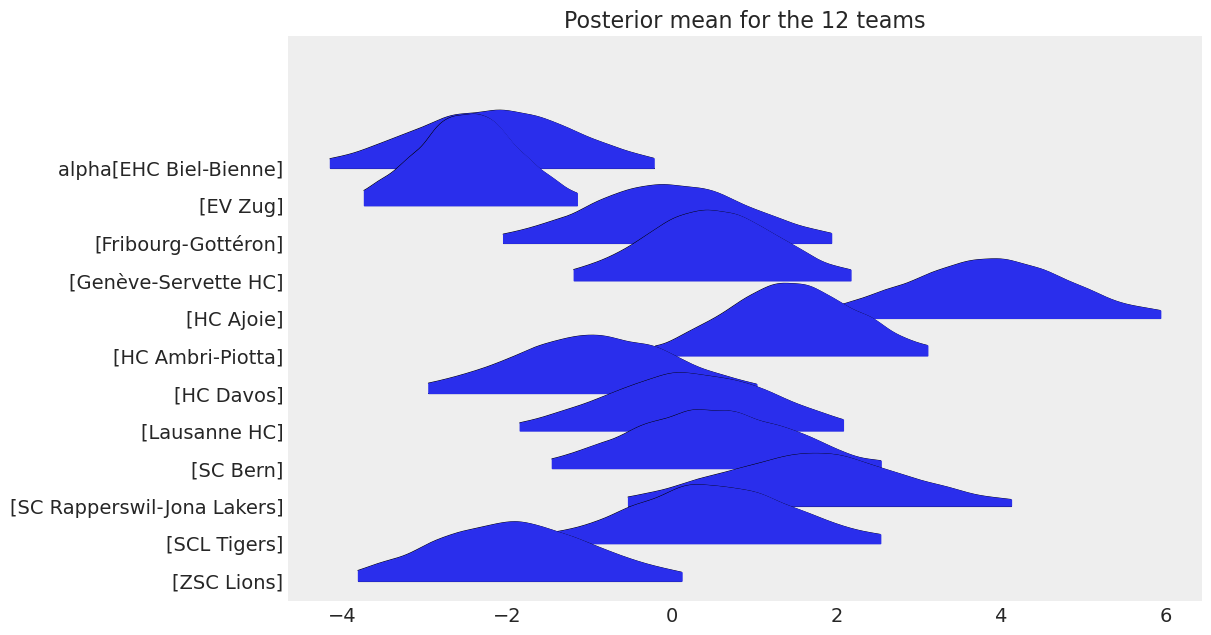

In [69]:
with unpooled_model:
    axes = az.plot_forest(unpooled_trace,  kind='ridgeplot', hdi_prob=0.95, var_names="alpha", combined=True, textsize=11)
    plt.title("Posterior mean for the 12 teams")

From the plot above we can make an estimate of which are the strong teams and which ones are not.

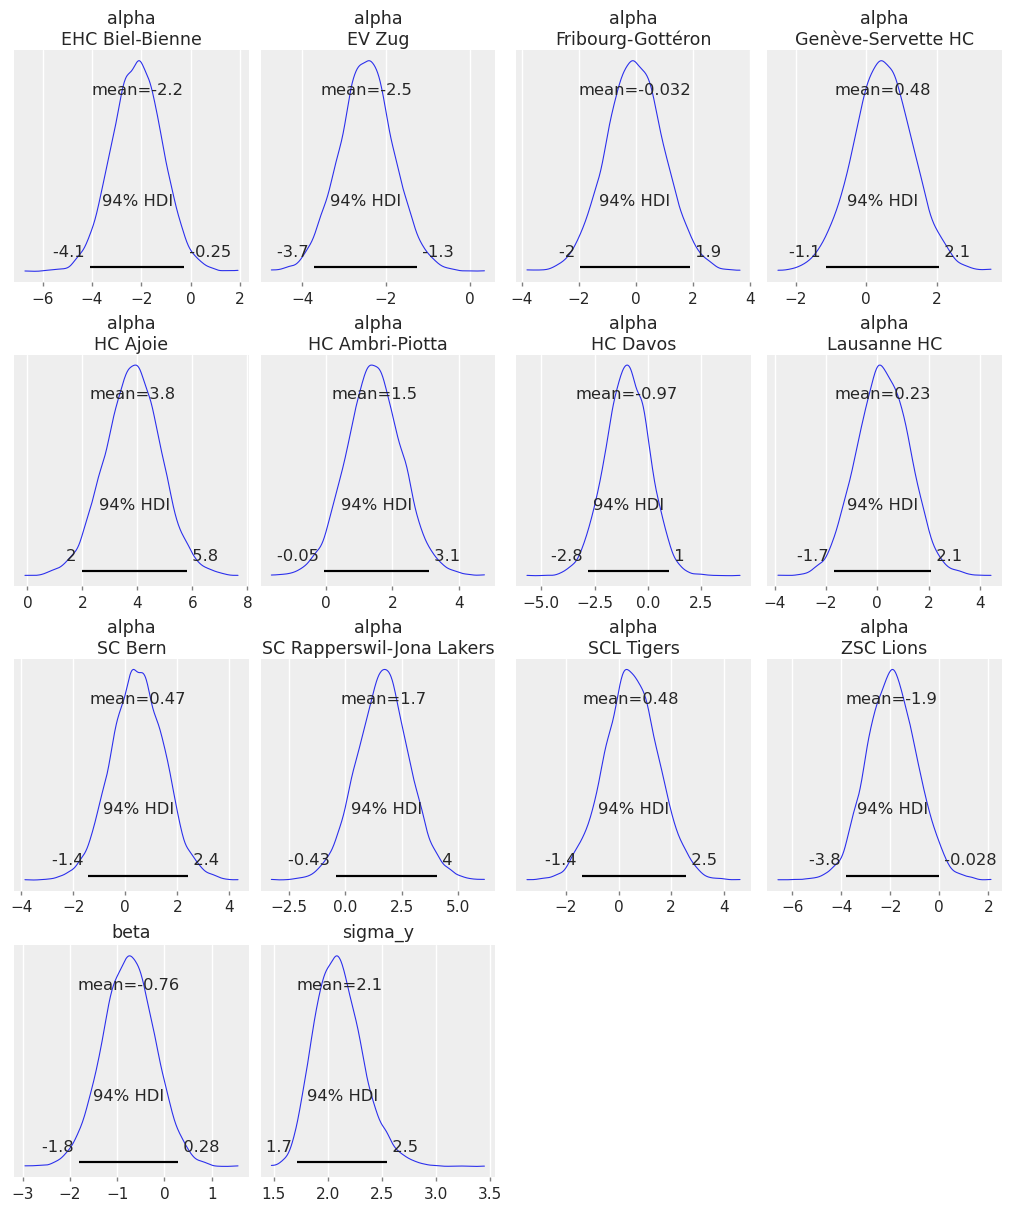

In [70]:
with unpooled_model:
    az.plot_posterior(unpooled_trace, figsize=(10,12), textsize=11)
    plt.tight_layout()

## Comparing the pooled and unpooled model

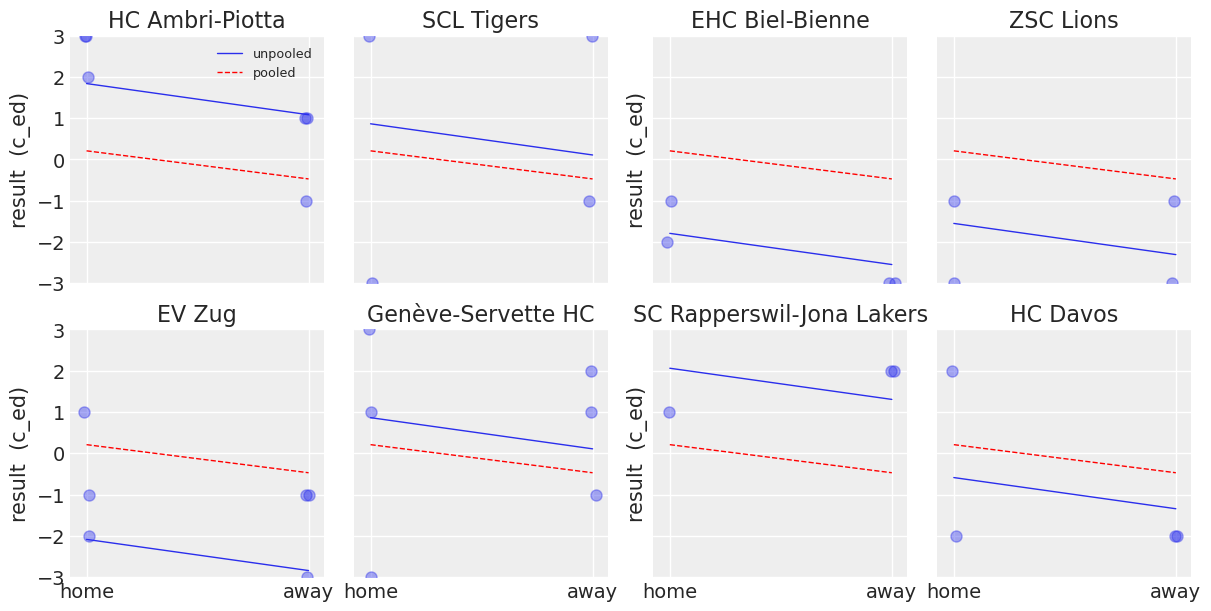

In [71]:
# The code below shows the pooled and unpooled model for some sample teams.
sample_teams = ('HC Ambri-Piotta', 'SCL Tigers', 'EHC Biel-Bienne', 'ZSC Lions', 'EV Zug', 'Genève-Servette HC', 'SC Rapperswil-Jona Lakers', 'HC Davos')
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

# slope of the unpooled model (posterior mean)
unpooled_post = az.extract_dataset(unpooled_trace)
beta_unpooled = unpooled_post.beta.values.mean()

alpha_unpooled = pd.Series(unpooled_post.alpha.values.mean(axis=1), index=teams)

for i,c in enumerate(sample_teams):
    #select the subset of observation referring to the specific team
    y = result[df.Opponent==c]
    x = place_c[df.Opponent==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    

    # Plot both models and data
    xvals = np.linspace(place_c.min(), place_c.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[c] + beta_unpooled * xvals,  label="unpooled" )
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    axes[i].set_xticks([place_c.min(), place_c.max()])
    axes[i].set_xticklabels(['home', 'away'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('result  (c_ed)')
    axes[0].legend()
plt.show()

The pooled model (red) is fixed and cannot identify high or low-scoring teams

# Hierarchical regression


* A different intercept for each team, modeling also the population of intercepts.


* This is referred to as a *varying intercept* model.


* Its estimates are a compromise between the unpooled and the pooled model.

# Hierarchical varying-intercept model

\begin{align}
Y &\sim N( \alpha_{j[i]} + \beta X_t,  \sigma) && \text{likelihood} \\
\beta & \sim N (0,2  \frac{s_y}{s_x} )  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 12&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(\bar{y},10 s_y)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of intercepts}\\
\end{align}

* Broad priors  on the parameters of the population of intercepts


* This is  a **varying-intercept** model, since the intercept is different for each team, while the slope is unique for all teams.


In [72]:
with pm.Model() as hier_model:
    
    # Parameters of the population of intercepts, to which we assign broad priors.
    mu_a = pm.Normal('mu_a', mu=mu_y, sigma=10 * s_y)
    sigma_a = pm.HalfNormal('sigma_a', 5 * s_y)
    
    # Each intercept is drawn from the population of intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_teams)
    
    # Common slope
    beta = pm.Normal('beta', mu=0, sigma= 2.5 *  s_y / s_x)
    
    # Prior on sigma
    sigma_y = pm.HalfNormal('sigma_y', 1.5 * s_y)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=alpha[team_idx] + beta * place_c, sigma=sigma_y, observed=result)    

In [73]:
with hier_model:
    hier_trace = pm.sample(draws=2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha, sigma_a, mu_a]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


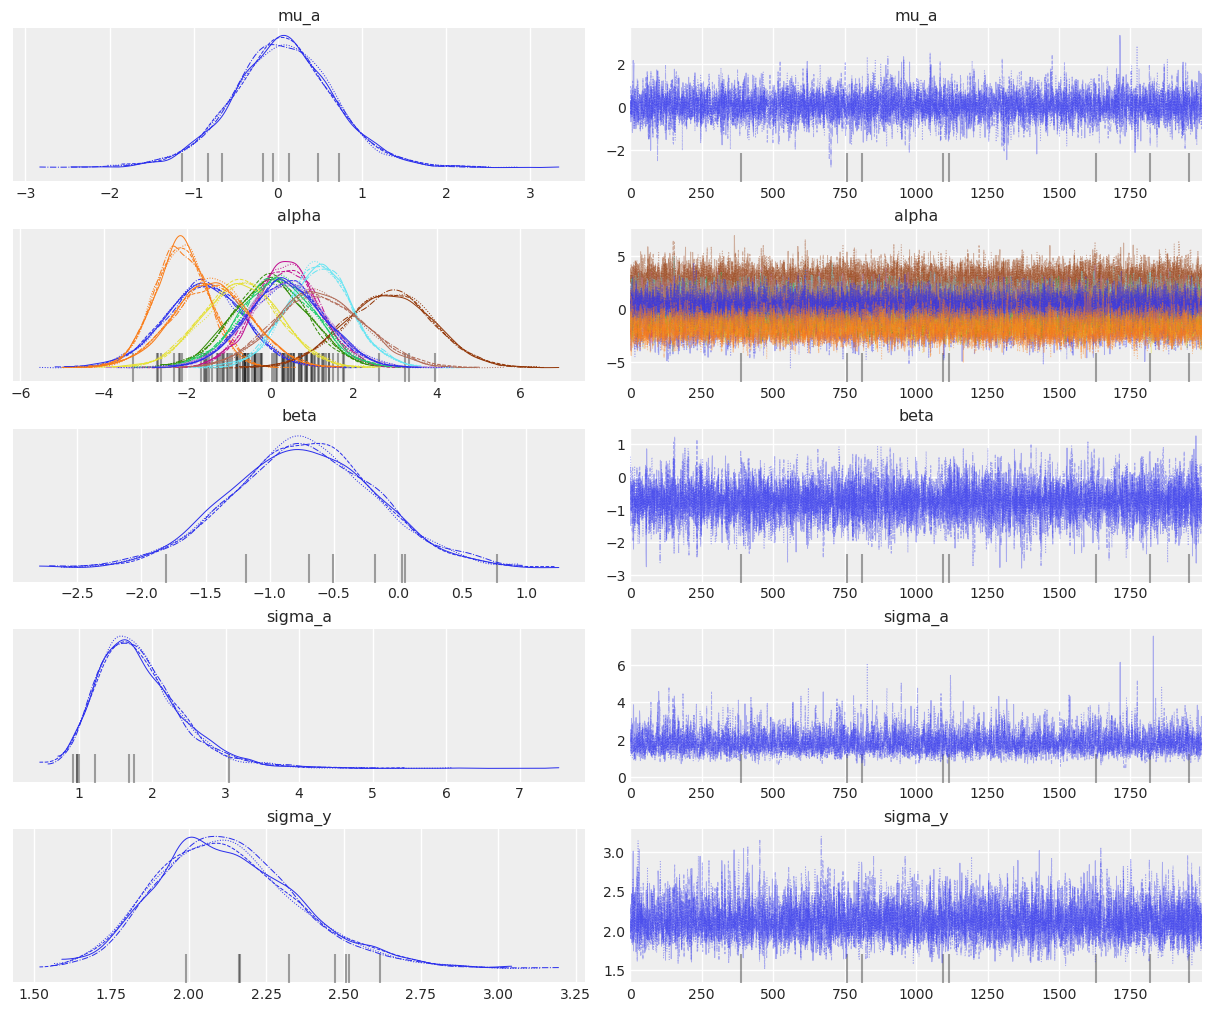

In [74]:
az.plot_trace(hier_trace)
plt.show()

In [75]:
hier_trace.posterior = hier_trace.posterior.assign_coords(alpha_dim_0=teams,
                                                                  beta_dim_0=teams,
                                                                 sigma_y_dim_0=teams)

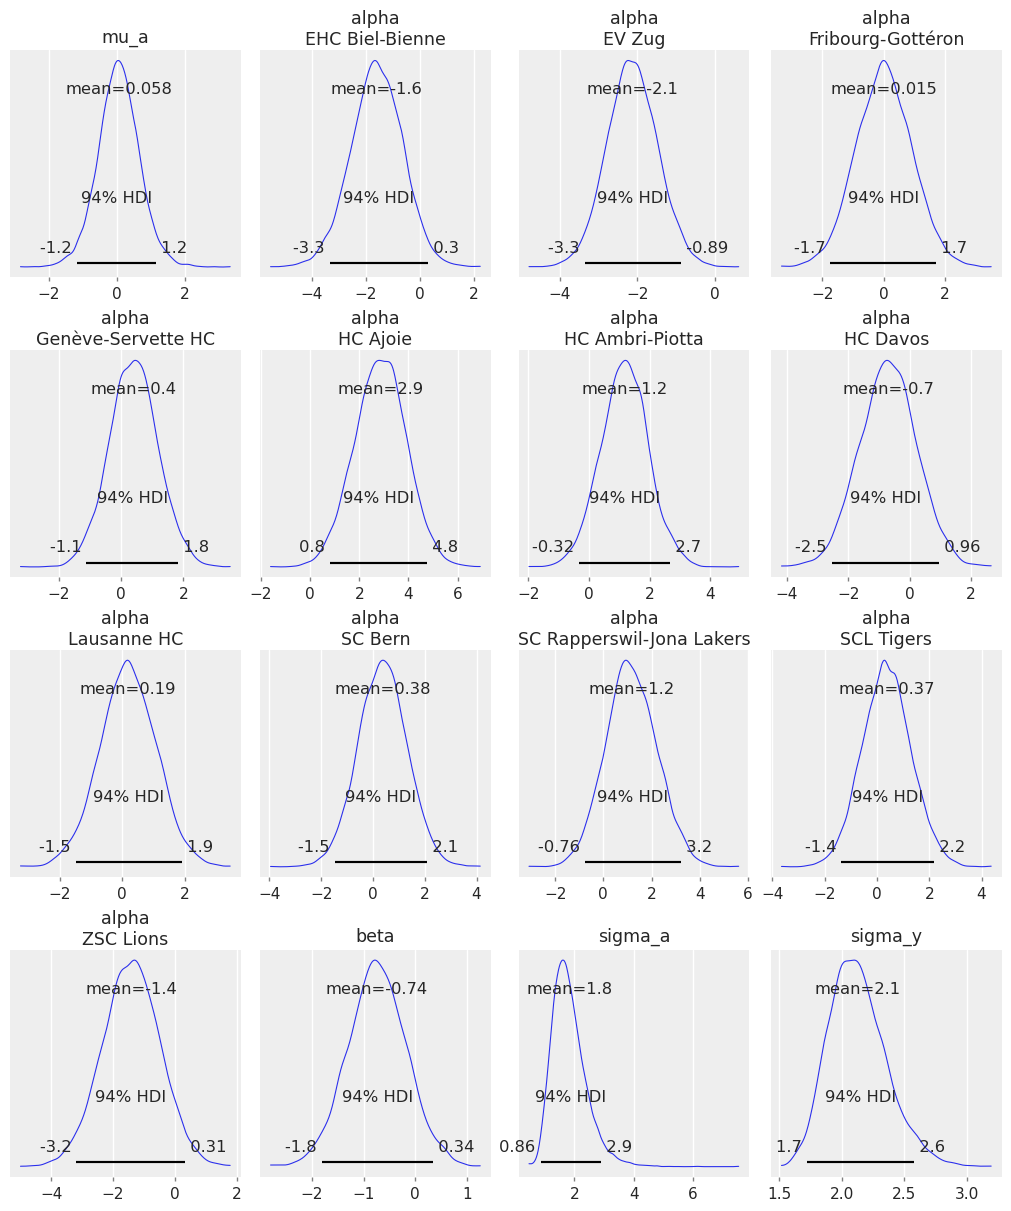

In [76]:
with hier_model:
    az.plot_posterior(hier_trace, figsize=(10,12), textsize=11)
    plt.tight_layout()

## Partial pooling 

* The estimate of the hierarchical model is a compromise (*partial pooling*) between the pooled and unpooled model.

* Estimates for teams with few observations (or very spread observations) are pulled  towards the estimate of the pooled model

* For teams with many observations, the estimates is closer to that of the  unpooled model.

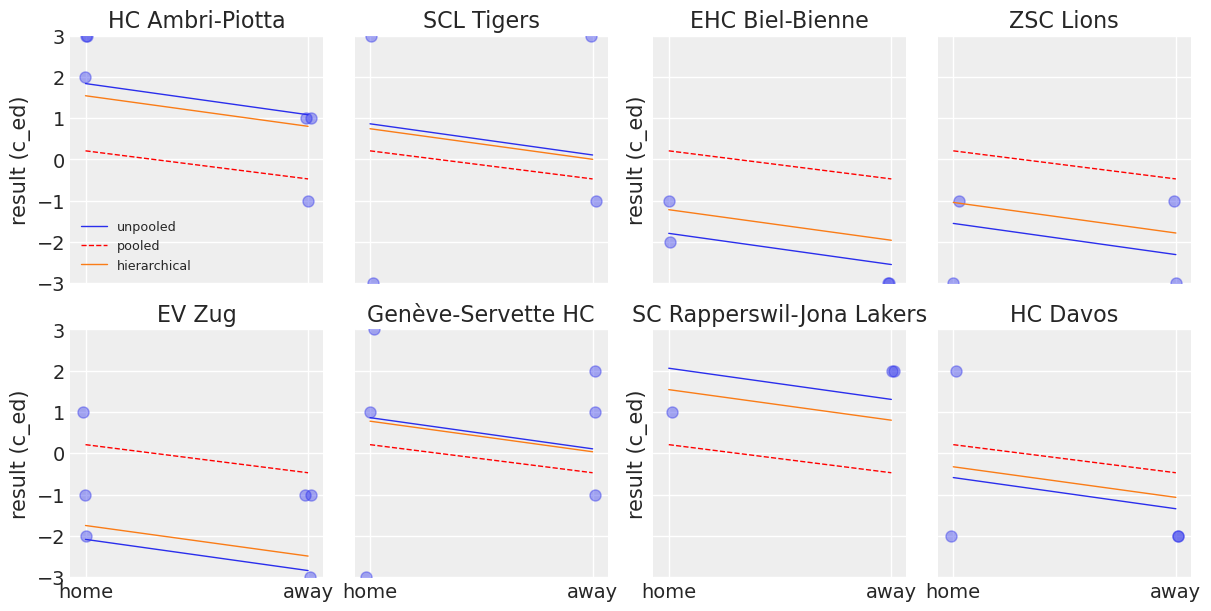

In [77]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

post_hier = az.extract_dataset(hier_trace.posterior)

# slope of the hier model (posterior mean)
beta_hier = post_hier.beta.values.mean()

# intercept of the hier model: an array, one element for each team
alpha_hier = pd.Series(post_hier.alpha.values.mean(axis=1), index=teams)


for i,c in enumerate(sample_teams):
    
    # Plot team data
    y = result[df.Opponent==c]
    x = place_c[df.Opponent==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    
    xvals = np.linspace(place_c.min(), place_c.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[team_lookup[c]] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[team_lookup[c]] + beta_hier * xvals,  label="hierarchical" )
    
    axes[i].set_xticks([place_c.min(), place_c.max()])
    axes[i].set_xticklabels(['home', 'away'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('result (c_ed)')
    axes[0].legend()

plt.show()

# Ranking models with WAIC

* WAIC is a model selection criterion for Bayesian models.

In [78]:
# the hierarchical model is ranked second
az.waic(pooled_trace) 
comp_df = az.compare({"model_pooled": pooled_trace,
                      "model_unpooled": unpooled_trace,
                      "model_hierarchical": hier_trace},
                      ic="waic") # ic stands for "information criterion"
comp_df

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model_hierarchical,0,-129.203344,10.103700,0.000000,0.714122,4.610161,0.000000,True,log
model_unpooled,1,-129.708962,11.734532,0.505618,0.236798,5.094003,1.112029,True,log
model_pooled,2,-137.918798,2.426905,8.715454,0.049081,3.760579,4.102740,False,log


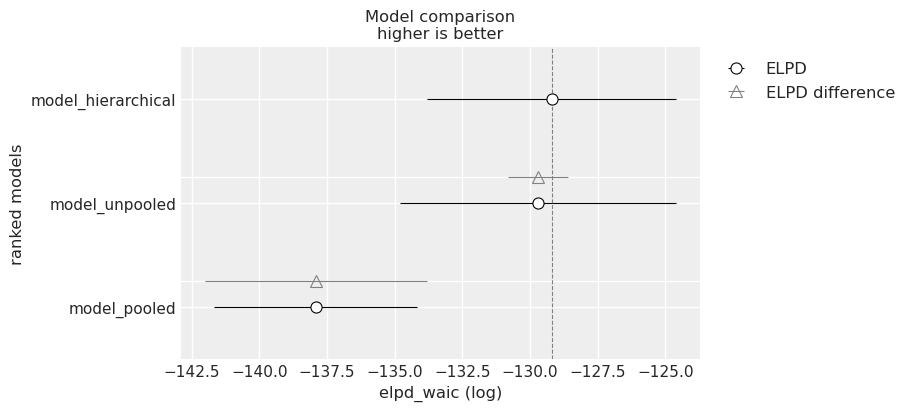

In [79]:
az.plot_compare(comp_df, figsize=(9,4), textsize=11);

# Prediction
There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group



In [80]:
# 1
# predictive distribution for a new result against HC-AP, according to the unpooled and the varying-intercept model
place_0 = np.unique(place_c)[0]

# get the trace samples
post_hier = az.extract_dataset(hier_trace.posterior)
post_unp = az.extract_dataset(unpooled_trace.posterior)

beta_hier = post_hier.beta.values
beta_unp = post_unp.beta.values

alpha_hcap_hier = post_hier.alpha.values[team_lookup['HC Ambri-Piotta']] 
alpha_hcap_unp = post_unp.alpha.values[team_lookup['HC Ambri-Piotta']] 

#samples of sd
sigma_y_hier = post_hier.sigma_y.values
sigma_y_unp = post_unp.sigma_y.values

In [81]:
y_new_hier = np.zeros(len(beta_hier))
y_new_unp = np.zeros(len(beta_unp))

# predictions for an existing team
for i, current_mu in enumerate(beta_hier):
        y_new_hier[i] = np.random.normal (loc = alpha_hcap_hier[i] + beta_hier[i] * place_0 , scale = sigma_y_hier[i])
        y_new_unp[i] = np.random.normal (loc = alpha_hcap_unp[i] + beta_unp[i] * place_0 , scale = sigma_y_unp[i])
        
a = pd.DataFrame(y_new_hier).describe()
b = pd.DataFrame(y_new_unp).describe()
c =  pd.concat ([a, b], axis=1)
c.columns = ['hier', 'unpooled']
c

,hier,unpooled
count,8000.000000,8000.000000
mean,1.498819,1.840035
std,2.297799,2.259333
min,-7.731128,-5.987967
25%,0.010486,0.352300
50%,1.487718,1.836128
75%,3.004992,3.346935
max,10.907043,14.478983


In [82]:
# 2
# predictive distribution for a measure taken in a new team.
post_hier = az.extract_dataset(hier_trace.posterior)

# First, we create plausible value of intercepts by sampling from the population of intercepts 
mu_a = post_hier.mu_a.values
sigma_a = post_hier.sigma_a.values
alpha_new = np.zeros(len(mu_a))

alpha_new = np.random.normal(loc = mu_a, scale = sigma_a)

 #samples of the slope and of the sigma   
beta_hier = post_hier.beta.values
sigma_y = post_hier.sigma_y.values

In [83]:
# predictive distribution for a new measure in the new team
y_new = np.zeros(len(alpha_new))

for i, current_mu in enumerate(alpha_new):
    y_new[i] = np.random.normal (loc = alpha_new[i] + beta_hier[i] *  place_0 , scale = sigma_y[i])

pd.DataFrame(y_new).describe()

,0
count,8000.000000
mean,0.402166
std,2.945661
min,-11.701426
25%,-1.573342
50%,0.377098
75%,2.303231
max,15.172161


# Varying-slope and varying-intercept model

\begin{align}
Y &\sim N( \alpha_{j[i]} + \beta X_t,  \sigma) && \text{likelihood} \\
\\
\beta_j &\sim N(\mu_{\beta}, \sigma_{\beta}) \,\, j=1,2..., 12&& \text{population of slopes} \\
\mu_{\beta} &\sim N(0,10 s_y)  && \text{prior on the mean slope} \\
\sigma_{\beta} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of slopes}\\
\\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 12&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(\bar{y},10 s_y)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of intercepts}\\
\\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
\end{align}

In [84]:
with pm.Model() as varying_slope_model:
    
    # Parameters of the population of intercepts, to which we assign broad priors.
    mu_a = pm.Normal('mu_a', mu=mu_y, sigma=10 * s_y)
    sigma_a = pm.HalfNormal('sigma_a', 5 * s_y)
    
    # Each intercept is drawn from the population of intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_teams)
    
    # Population of slopes
    mu_b = pm.Normal('mu_b', mu=0, sigma=10 * s_y)
    sigma_b = pm.HalfNormal('sigma_b', 5 * s_y)
    beta = pm.Normal('beta', mu=mu_b, sigma= sigma_b)
    
    # Prior on sigma
    sigma_y = pm.HalfNormal('sigma_y', 1.5 * s_y)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=alpha[team_idx] + beta * place_c, sigma=sigma_y, observed=result)    

In [85]:
with varying_slope_model:
    varying_slope_trace = pm.sample(draws=2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, sigma_b, mu_b, alpha, sigma_a, mu_a]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
There were 518 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6443743278178682, but should be close to 0.8. Try to increase the number of tuning steps.
There were 278 divergences after tuning. Increase `target_accept` or reparameterize.
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.
There were 307 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


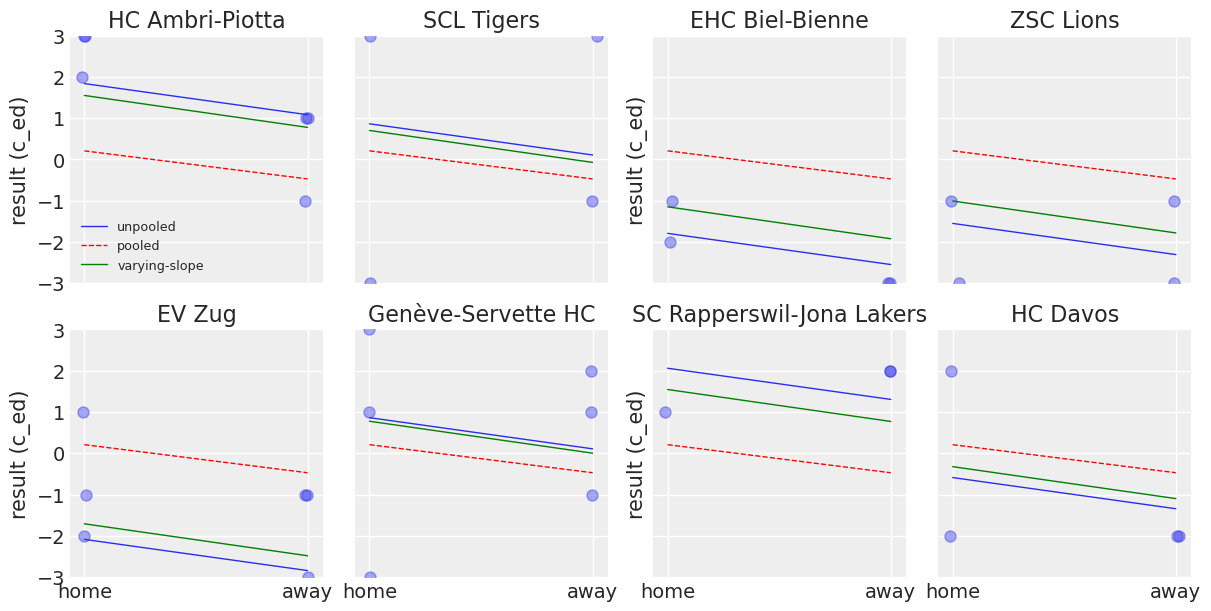

In [86]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

post_var = az.extract_dataset(varying_slope_trace.posterior)

# slope of the varying-slope model (posterior mean)
beta_var = post_var.beta.values.mean()

# intercept of the varying-slope model: an array, one element for each team
alpha_var = pd.Series(post_var.alpha.values.mean(axis=1), index=teams)


for i,c in enumerate(sample_teams):
    
    # Plot team data
    y = result[df.Opponent==c]
    x = place_c[df.Opponent==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    
    xvals = np.linspace(place_c.min(), place_c.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[team_lookup[c]] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_var[team_lookup[c]] + beta_var * xvals,  label="varying-slope", c='g')
    
    axes[i].set_xticks([place_c.min(), place_c.max()])
    axes[i].set_xticklabels(['home', 'away'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('result (c_ed)')
    axes[0].legend()

plt.show()

In [87]:
# the varying slope is ranked second
az.waic(pooled_trace) 
comp_df = az.compare({"model_pooled": pooled_trace,
                      "model_unpooled": unpooled_trace,
                      "model_hierarchical": hier_trace,
                      "model_varying_slope": varying_slope_trace},
                      ic="waic")
comp_df

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model_varying_slope,0,-128.899302,9.690733,0.000000,1.000000e+00,4.549486,0.000000,True,log
model_hierarchical,1,-129.203344,10.103700,0.304042,0.000000e+00,4.610161,0.156109,True,log
model_unpooled,2,-129.708962,11.734532,0.809660,8.326673e-17,5.094003,1.202709,True,log
model_pooled,3,-137.918798,2.426905,9.019496,0.000000e+00,3.760579,4.014096,False,log


<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

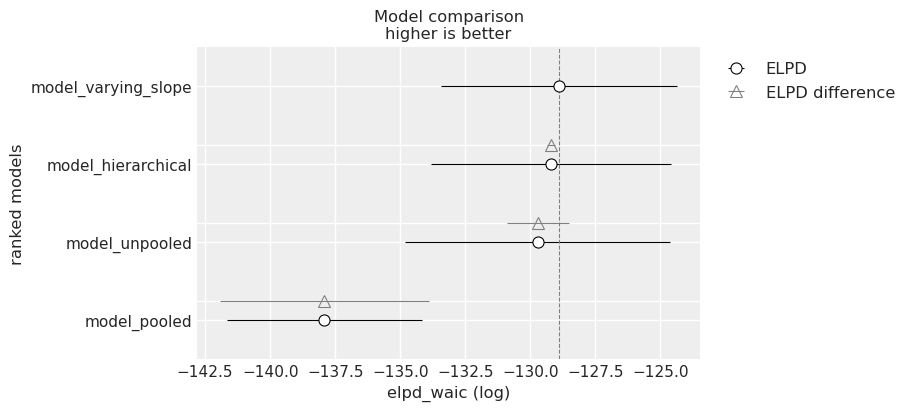

In [88]:
az.plot_compare(comp_df, figsize=(9,4), textsize=11)

In [89]:
# predictive distribution for HC Ambri-Piotta
# get the trace samples
post_hier_vt = az.extract_dataset(varying_slope_trace.posterior)

# samples of the intercept for Ambri-Piotta
alpha_hcap_vt = post_hier_vt.alpha.values[team_lookup['HC Ambri-Piotta']] 

# samples of the slope for Ambri-Piotta
beta_hcap_vt = post_hier_vt.beta.values[team_lookup['HC Ambri-Piotta']] 

# samples of sd
sigma_y_vt =  post_hier_vt.sigma_y.values

y_new_vt = np.zeros(len(alpha_hcap_vt))
y_new_vt = np.random.normal (loc = alpha_hcap_vt + beta_hcap_vt *  place_0 , scale = sigma_y_vt)

pd.DataFrame(y_new_vt).describe()

,0
count,8000.000000
mean,1.460576
std,2.296209
min,-6.665562
25%,-0.062714
50%,1.464673
75%,3.015003
max,10.741247
